In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import os

In [2]:
file_list = [f"C:/Users/alexl/Documents/GitHub/Meteo/maps/arome_data/2024-08-26T06-00-00Z/{file}" for file in os.listdir('C:/Users/alexl/Documents/GitHub/Meteo/maps/arome_data/2024-08-26T06-00-00Z')]
backend_kwargs = {
    'filter_by_keys': {
        'typeOfLevel': 'heightAboveGround',
        'level': 2
    }
}
datasets = [xr.open_dataset(f, engine='cfgrib', backend_kwargs=backend_kwargs) for f in file_list]
ds = xr.concat(datasets, dim='step')

In [3]:
ds['t2m'] = ds['t2m'] - 273.15

In [ ]:
ds.t2m[0].plot()

In [5]:
dsf = ds.to_dataframe()
dsf = dsf.reset_index()
#dsf_lat_lon = dsf[['latitude', 'longitude']].values.tolist()
#len(dsf_lat_lon)

KeyboardInterrupt: 

In [ ]:
geo_dep = gpd.read_file('geojsonfrance.json')
geo_dep = geo_dep.rename(columns={'code': 'Dep'})
gdf = gpd.read_file('france.json')
geo_dep

In [7]:
minx, miny, maxx, maxy = gdf.total_bounds.round(2)
print(minx, miny, maxx, maxy)
resolution = 0.01
x_coords = np.arange(minx, maxx, resolution)
y_coords = np.arange(miny, maxy, resolution)
grid_points = [[round(x, 2), round(y, 2)] for x in x_coords for y in y_coords]
len(grid_points)

-4.59 41.38 9.56 51.15


1382455

In [8]:
#df = pd.DataFrame(grid_points, columns=['longitude', 'latitude'])
#df.to_csv('france_coords.csv')

In [20]:
lat_lon = pd.read_csv('france_coords.csv')[['longitude', 'latitude']]
dsf['latitude'] = round(dsf['latitude'], 2)
dsf['longitude'] = round(dsf['longitude'], 2)

dsf_france = pd.merge(dsf, lat_lon, on=['latitude', 'longitude'], how='inner')
dsf_france

,step,latitude,longitude,t2m,r2,time,heightAboveGround,valid_time
0,0 days 00:00:00,51.14,-4.59,17.183807,95.127502,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
1,0 days 00:00:00,51.14,-4.58,17.186737,95.127502,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
2,0 days 00:00:00,51.14,-4.57,17.191620,95.127502,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
3,0 days 00:00:00,51.14,-4.56,17.191620,95.221252,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
4,0 days 00:00:00,51.14,-4.55,17.185760,95.346252,2024-08-22 06:00:00,2.0,2024-08-22 06:00:00
...,...,...,...,...,...,...,...,...
5529815,0 days 03:00:00,41.38,9.51,25.981720,76.718987,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00
5529816,0 days 03:00:00,41.38,9.52,25.992462,76.718987,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00
5529817,0 days 03:00:00,41.38,9.53,25.996368,76.812737,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00
5529818,0 days 03:00:00,41.38,9.54,26.000275,76.906487,2024-08-22 06:00:00,2.0,2024-08-22 09:00:00


In [21]:
mean_dsf_france = dsf_france.groupby(['latitude', 'longitude']).mean().reset_index()[['latitude', 'longitude', 't2m']]
mean_dsf_france

,latitude,longitude,t2m
0,41.38,-4.59,20.640282
1,41.38,-4.58,20.798729
2,41.38,-4.57,20.941307
3,41.38,-4.56,21.032127
4,41.38,-4.55,21.115379
...,...,...,...
1382450,51.14,9.51,15.397362
1382451,51.14,9.52,15.430809
1382452,51.14,9.53,15.646629
1382453,51.14,9.54,15.867088


In [10]:
ds_plot = mean_dsf_france.set_index(['latitude', 'longitude']).to_xarray()

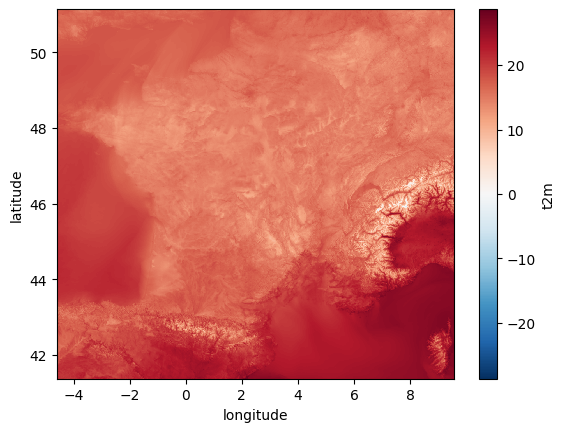

In [11]:
ds_plot.t2m.plot()

In [12]:
df_dep = pd.read_csv('points-extremes-des-departements-metropolitains-de-france.csv')
df_dep = df_dep.rename(columns={'Departement': 'Dep',
                                'Latitude la plus au nord': 'LatMax',
                                'Latitude la plus au sud': 'LatMin',
                                'Longitude la plus à l’est': 'LongMax', 
                                'Longitude la plus à l’ouest': 'LongMin'})
df_dep = round(df_dep, 2)

In [13]:
lst = []
resolution = 0.01
for i, row in df_dep.iterrows():
    x_coords = np.arange(row['LongMin'], row['LongMax'], resolution)
    y_coords = np.arange(row['LatMin'], row['LatMax'], resolution)
    grid_points = [Point(round(x, 2), round(y, 2)) for x in x_coords for y in y_coords]
    #lst.append(pd.DataFrame(grid_points, columns=['longitude', 'latitude']))
    lst.append(grid_points)
df_dep['grid_points'] = lst

In [14]:
df_dep = pd.merge(df_dep, geo_dep, on='Dep', how='inner')

In [15]:
df_dep

,Dep,LatMax,LatMin,LongMax,LongMin,grid_points,nom,geometry
0,01,46.52,45.61,6.17,4.73,"[POINT (4.73 45.61), POINT (4.73 45.62), POINT...",Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,50.07,48.84,4.25,2.96,"[POINT (2.96 48.84), POINT (2.96 48.85), POINT...",Aisne,"POLYGON ((3.1727 50.012, 3.1822 50.01234, 3.21..."
2,03,46.80,45.93,4.01,2.28,"[POINT (2.28 45.93), POINT (2.28 45.94), POINT...",Allier,"POLYGON ((3.03206 46.79491, 3.03684 46.7844, 3..."
3,04,44.66,43.67,6.97,5.50,"[POINT (5.5 43.67), POINT (5.5 43.68), POINT (...",Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,45.13,44.19,7.08,5.42,"[POINT (5.42 44.19), POINT (5.42 44.2), POINT ...",Hautes-Alpes,"POLYGON ((6.26057 45.12684, 6.2755 45.1153, 6...."
...,...,...,...,...,...,...,...,...
91,93,49.01,48.81,2.60,2.29,"[POINT (2.29 48.81), POINT (2.29 48.82), POINT...",Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.56579 49.0124, 2..."
92,94,48.86,48.69,2.61,2.31,"[POINT (2.31 48.69), POINT (2.31 48.7), POINT ...",Val-de-Marne,"POLYGON ((2.3319 48.81701, 2.36395 48.81631, 2..."
93,95,49.23,48.91,2.59,1.61,"[POINT (1.61 48.91), POINT (1.61 48.92), POINT...",Val-d'Oise,"POLYGON ((1.70436 49.2322, 1.72966 49.2292, 1...."
94,2A,42.38,41.36,9.41,8.54,"[POINT (8.54 41.36), POINT (8.54 41.37), POINT...",Corse-du-Sud,"MULTIPOLYGON (((9.27103 41.36496, 9.2657 41.36..."


In [16]:
list_dep = []
for i, row in df_dep.iterrows():
    mask = row['geometry'].contains(row['grid_points'])
    dep_points = np.array(row['grid_points'])[np.array(mask)]
    list_dep.append(dep_points)
df_dep['dep_points'] = list_dep

In [25]:
df_dep

,Dep,LatMax,LatMin,LongMax,LongMin,grid_points,nom,geometry,dep_points
0,01,46.52,45.61,6.17,4.73,"[POINT (4.73 45.61), POINT (4.73 45.62), POINT...",Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...","[POINT (4.74 45.94), POINT (4.74 45.95), POINT..."
1,02,50.07,48.84,4.25,2.96,"[POINT (2.96 48.84), POINT (2.96 48.85), POINT...",Aisne,"POLYGON ((3.1727 50.012, 3.1822 50.01234, 3.21...","[POINT (2.97 49.2), POINT (2.97 49.22), POINT ..."
2,03,46.80,45.93,4.01,2.28,"[POINT (2.28 45.93), POINT (2.28 45.94), POINT...",Allier,"POLYGON ((3.03206 46.79491, 3.03684 46.7844, 3...","[POINT (2.29 46.39), POINT (2.29 46.4), POINT ..."
3,04,44.66,43.67,6.97,5.50,"[POINT (5.5 43.67), POINT (5.5 43.68), POINT (...",Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ...","[POINT (5.5 44.08), POINT (5.5 44.09), POINT (..."
4,05,45.13,44.19,7.08,5.42,"[POINT (5.42 44.19), POINT (5.42 44.2), POINT ...",Hautes-Alpes,"POLYGON ((6.26057 45.12684, 6.2755 45.1153, 6....","[POINT (5.43 44.42), POINT (5.43 44.43), POINT..."
...,...,...,...,...,...,...,...,...,...
91,93,49.01,48.81,2.60,2.29,"[POINT (2.29 48.81), POINT (2.29 48.82), POINT...",Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.56579 49.0124, 2...","[POINT (2.3 48.95), POINT (2.3 48.96), POINT (..."
92,94,48.86,48.69,2.61,2.31,"[POINT (2.31 48.69), POINT (2.31 48.7), POINT ...",Val-de-Marne,"POLYGON ((2.3319 48.81701, 2.36395 48.81631, 2...","[POINT (2.32 48.75), POINT (2.32 48.76), POINT..."
93,95,49.23,48.91,2.59,1.61,"[POINT (1.61 48.91), POINT (1.61 48.92), POINT...",Val-d'Oise,"POLYGON ((1.70436 49.2322, 1.72966 49.2292, 1....","[POINT (1.62 49.08), POINT (1.63 49.08), POINT..."
94,2A,42.38,41.36,9.41,8.54,"[POINT (8.54 41.36), POINT (8.54 41.37), POINT...",Corse-du-Sud,"MULTIPOLYGON (((9.27103 41.36496, 9.2657 41.36...","[POINT (8.55 42.23), POINT (8.55 42.37), POINT..."


In [17]:
df_dep['dep_coords'] = df_dep['dep_points'].apply(lambda points: np.array([[point.x, point.y] for point in points]))

In [22]:
df_exploded = df_dep.explode('dep_coords')
df_exploded[['longitude', 'latitude']] = pd.DataFrame(df_exploded['dep_coords'].tolist(), index=df_exploded.index)
df_multiindex = df_exploded.set_index(['Dep', 'nom'])
df_multiindex[['longitude', 'latitude']].to_csv('coords_dep_001.csv')